In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
from os.path import join as oj
import numpy as np
import matplotlib.ticker as mtick
from copy import deepcopy
# plt.style.use('dark_background')
import sys
sys.path.append('../src')
import data
import pickle as pkl
import viz
from viz import *
import analyze_helper, train
from sklearn import metrics
from config import *
import pandas as pd
from tqdm import tqdm

# select model directory + model name
# out_dir = oj(DIR_RESULTS, 'may7_1') # mar7_2 is 0.95, mar8_1 is 0.96
# out_dir = oj(DIR_RESULTS, 'nov16') # mar7_2 is 0.95, mar8_1 is 0.96
out_dir = '../models'
r = analyze_helper.load_results(out_dir)
r = r.sort_values('accuracy', ascending=False)
idx = np.array(r.index)
accs = np.array(r.accuracy)
model_name = idx[0]
# model_name = 'mlp2_17_select_lasso=7_ros=1_h=0_cal=True'

# print accs
print('using model', model_name)
for i in range(min(accs.size, 5)):
    print(f'\t{accs[i]:.3f}', idx[i])

# get data
outcome_def = 'y_consec_thresh'
df = data.get_data()
n = df.shape[0]
df_cv = df[df.valid == 1] # exclude test cells, short/long tracks, hotspots
X, y, norms = analyze_helper.normalize(df_cv, outcome_def)

# load model + preds
d_full_cv, idxs_cv = analyze_helper.get_data_over_folds(model_name, out_dir, df_cv.cell_num, X, y)
y_full_cv = df_cv[outcome_def].iloc[idxs_cv].values.astype(np.int)
preds_cv = d_full_cv[model_name].values
preds_proba_cv = d_full_cv[model_name + '_proba'].values

results_individual = pkl.load(open(oj(out_dir, f'{model_name}.pkl'), 'rb'))
assert np.sum(idxs_cv == np.arange(idxs_cv.size)) == idxs_cv.size, \
       'points not in same order'
assert np.mean(preds_cv==y_full_cv) == np.average(results_individual['cv']['accuracy'], 
                                               weights=results_individual['num_pts_by_fold_cv']), \
        'did not properly load model/data'
tp, tn, fp, fn = analyze_helper.calc_errs(preds_cv, y_full_cv)
print('succesfully loaded!')

# dynamin analysis

In [2]:
dset_name = 'clath_aux_dynamin'
m0 = results_individual['imps']['model'][0]
feat_names_selected = results_individual['feat_names_selected']
df_new, y_new, preds_new, preds_proba_new, Y_maxes = \
    analyze_helper.normalize_and_predict(m0, feat_names_selected, dset_name, normalize_by_train=False)
tp, tn, fp, fn = analyze_helper.calc_errs(preds_new, y_new)
def norm(x):
    return (x - np.mean(x)) / np.std(x)
df_new['Z_max'] = [max(z) for z in df_new['Z']]
df_new['Z_max_normed'] = norm(df_new['Z_max'])
df_new['Y_max_normed'] = norm(df_new['Y_max'])

In [ ]:
# visualize the biggest errors
num_to_plot = 5
# print('total pts', preds.shape[0])
# for idxs, name in zip([fp, fn, tp, tn], ['fp', 'fn', 'tp', 'tn']):
for idxs, name in zip([fp, fn], ['fp', 'fn']):
# for idxs, name in zip([tp, tn], ['tp', 'tn']):
    print(name)
    inds = viz.viz_biggest_errs(df_new, None, idxs,
                                y_new,
                                preds_new,
                                preds_proba_new,
                                num_to_plot,
                                plot_x=True,
                                plot_z=True,
                                xlim_constant=False)
    plt.legend()
#     plt.savefig(f'{name}.pdf')
    plt.show()

In [ ]:
# visualize the biggest errors
num_to_plot = 5
# print('total pts', preds.shape[0])
# for idxs, name in zip([fp, fn, tp, tn], ['fp', 'fn', 'tp', 'tn']):
for idxs, name in zip([fp], ['fp']):
# for idxs, name in zip([tp, tn], ['tp', 'tn']):
    print(name)
    inds = viz.viz_biggest_errs(df_new, None, idxs,
                                y_new,
                                preds_new,
                                preds_proba_new,
                                num_to_plot,
                                plot_x=False,
                                plot_z=True,
                                xlim_constant=False)
#     plt.legend()
#     plt.savefig(f'{name}.pdf')
    plt.show()

# false positives / true negs

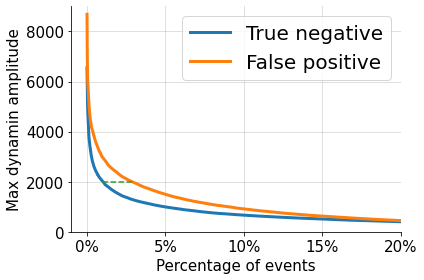

In [33]:
# plt.figure(figsize=(6, 4.5), dpi=200)
zs2 = sorted(df_new[tn]['Z_max'])[::-1]
ax = plt.subplot(111)
zs2x = np.arange(len(zs2)) / df_new.shape[0] * 100
ax.plot(zs2x, zs2, label='True negative', lw=3)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

zs = sorted(df_new[fp]['Z_max'])[::-1]
zsx = np.arange(len(zs)) / df_new.shape[0] * 100
plt.plot(zsx, zs, label='False positive', lw=3)

i = 1400
plt.plot([zsx[i], zsx[i] - 2],
         [zs[i], zs[i]], '--')
plt.xlim((-1, 20))
plt.ylim((0, 9000))
plt.legend(fontsize=20)
plt.grid(alpha=0.5)
plt.ylabel('Max dynamin amplitude')
plt.xlabel('Percentage of events')
viz.savefig('dyn_diff')
plt.show()

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(df_new[fp]['Y_max'], df_new[fp]['Z_max'],
         'o', alpha=0.3, ms=0.5)
plt.xlabel('aux max')
plt.ylabel('dyn max')
plt.show()

In [8]:
R, C = 6, 6
ylim_constant=False
xlim_constant=True
legend=True
plot_x=True
lifetime_max = np.max(df.lifetime.values[:R * C])

In [12]:
np.linspace(0, df_new.shape[0], R*C - 1)
d = df_new.sort_values('Z_max').iloc[np.linspace(35000, df_new.shape[0] - 1, R*C).astype(int)]

In [ ]:
plt.figure(figsize=(16, 12))
for i in tqdm(range(R * C)):
    if i < d.shape[0]:
        plt.subplot(R, C, i + 1)
        row = d.iloc[i]
        if plot_x:
            plt.plot(row.X, color=cr, label='clathrin')
#         if extra_key is not None:
        plt.plot(row.Z, color=cp, label='dyn')
        plt.title(int(row.Z_max), color=cp)
        if ylim_constant:
            plt.ylim([-10, max(max(d.X_max), max(d.Y_max)) + 1])
        plt.axhline(642.3754691658837, color='gray', alpha=0.5)
        plt.xticks([])
plt.tight_layout()